# [Hands-On] Understanding Autoencoder and Implementation

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

This lecture is part of the generative model series, specifically focusing on the use of autoencoders (AEs) for image compression and reconstruction tasks.

### What is an Autoencoder?

An autoencoder is a type of artificial neural network used to learn efficient codings of input data. The network is trained to map input data to itself, typically through a bottleneck layer that represents the data in a lower-dimensional latent space. This bottleneck forces the autoencoder to compress the input data, capturing the most salient features, and then reconstruct it from this compressed representation.

### In this Notebook:

We will demonstrate the use of autoencoders for compressing and reconstructing images from the MNIST dataset. Starting with a simple autoencoder with a 2-dimensional latent space, we will explore its limitations and then improve the reconstruction quality by increasing the dimensionality of the latent space.

**Objectives:**
1. Understand the basic structure and functioning of an autoencoder.
2. Implement an autoencoder to learn and reconstruct the MNIST dataset.
3. Evaluate the performance and visualize the reconstructed images.
4. Analyze the latent space representation and its limitations.
5. Explore the transition from basic autoencoders to Variational Autoencoders (VAEs) for learning continuous and meaningful latent spaces.

By the end of this lecture, you will gain practical insights into the workings of autoencoders, understand the importance of latent space dimensionality, and recognize the potential for further advancements with VAEs.

Let's dive into the fascinating world of autoencoders!

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Function to set the seed for reproducibility
import random
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

## Autoencoder Structure
An autoencoder is a neural network designed to compress input data into a lower-dimensional latent space and then reconstruct it back to its original dimensions. In the forward method, the output is composed of encoded and decoded values, where encoded represents the compressed latent representation of the input data, and decoded is the reconstruction from this representation.

In [ ]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 500),
            nn.ReLU(),
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Linear(100, 2)  # Bottleneck layer with 2 dimensions
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 100),
            nn.ReLU(),
            nn.Linear(100, 500),
            nn.ReLU(),
            nn.Linear(500, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## Dataset Preparation
The MNIST dataset consists of 70,000 images of handwritten digits (0-9), each of size 28x28 pixels. It is a widely used benchmark in the field of machine learning for image classification and generation tasks.

In [ ]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15782133.69it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490557.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4311443.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1837080.88it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Image Shape :  torch.Size([1, 28, 28])
Image Data
tensor(0.) tensor(1.)
The pixel data ranges between 0 and 1.


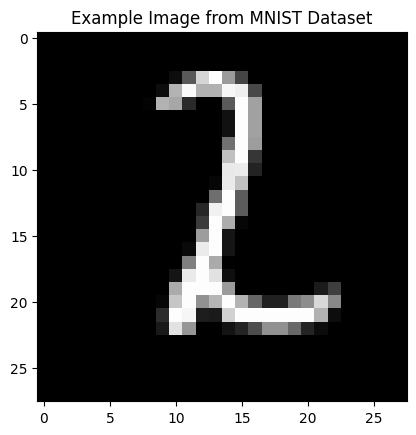

In [ ]:
# Examine the result and real

# Get a batch of training data
images, labels = next(iter(train_loader))

# Select a random image from the batch
random_index = random.randint(0, len(images) - 1)
selected_image = images[random_index]

print("Image Shape : ", selected_image.shape)
print("Image Data")
print(selected_image.min(), selected_image.max())
print("The pixel data ranges between 0 and 1.")

# Display the image
plt.imshow(selected_image.view(28, 28), cmap="gray")
plt.title("Example Image from MNIST Dataset")
plt.show()

## Training

We define and train the autoencoder model using the MNIST dataset. The loss function for the autoencoder can be either Binary Cross-Entropy (BCE) or Mean Squared Error (MSE), which can be adjusted to optimize the reconstruction quality.

In [ ]:
# Initialize the autoencoder, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(-1, 784).to(device)  # Move inputs to the same device as the model

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        encoded, outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.2245
Epoch [2/100], Loss: 0.1965
Epoch [3/100], Loss: 0.2056
Epoch [4/100], Loss: 0.1917
Epoch [5/100], Loss: 0.1832
Epoch [6/100], Loss: 0.1791
Epoch [7/100], Loss: 0.1806
Epoch [8/100], Loss: 0.1698
Epoch [9/100], Loss: 0.1821
Epoch [10/100], Loss: 0.1657
Epoch [11/100], Loss: 0.1911
Epoch [12/100], Loss: 0.1716
Epoch [13/100], Loss: 0.1658
Epoch [14/100], Loss: 0.1801
Epoch [15/100], Loss: 0.1752
Epoch [16/100], Loss: 0.1611
Epoch [17/100], Loss: 0.1706
Epoch [18/100], Loss: 0.1679
Epoch [19/100], Loss: 0.1637
Epoch [20/100], Loss: 0.1729
Epoch [21/100], Loss: 0.1849
Epoch [22/100], Loss: 0.1651
Epoch [23/100], Loss: 0.1702
Epoch [24/100], Loss: 0.1661
Epoch [25/100], Loss: 0.1659
Epoch [26/100], Loss: 0.1713
Epoch [27/100], Loss: 0.1630
Epoch [28/100], Loss: 0.1655
Epoch [29/100], Loss: 0.1594
Epoch [30/100], Loss: 0.1745
Epoch [31/100], Loss: 0.1646
Epoch [32/100], Loss: 0.1743
Epoch [33/100], Loss: 0.1666
Epoch [34/100], Loss: 0.1605
Epoch [35/100], Loss: 0

## Evaluation and Visualization
Here, we evaluate the performance of the autoencoder by visualizing the reconstructed images. Although the model can recover the original images to some extent, the reconstruction is incomplete and often quite blurry due to the 2D latent space representation.

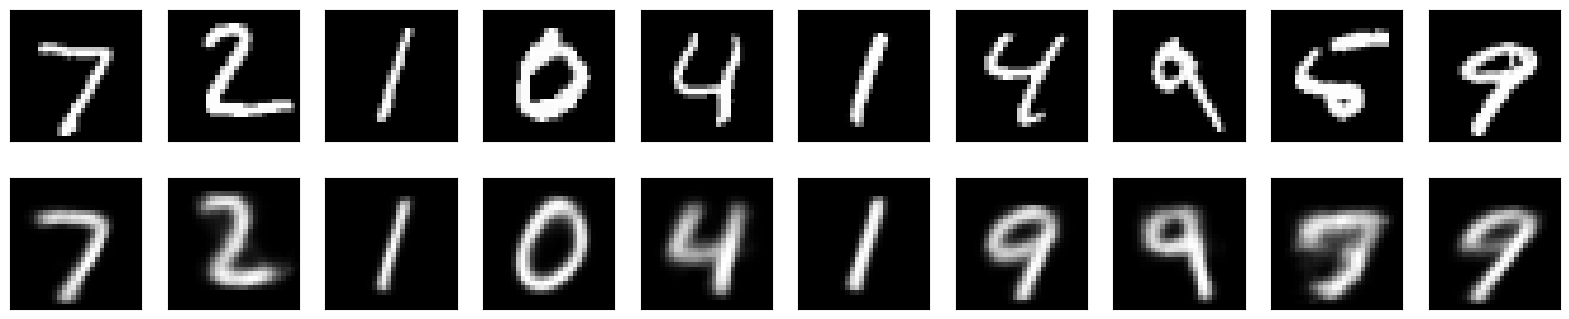

In [ ]:
# Test the autoencoder
model.eval()
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        inputs = inputs.view(-1, 784).to(device)
        encoded, outputs = model(inputs)
        break

# Visualize the original and reconstructed images
# Reshape the flattened vectors back to 2D images (28x28)
# -1 keeps the batch size intact
inputs = inputs.view(-1, 28, 28)
outputs = outputs.view(-1, 28, 28)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(inputs[i].cpu().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].cpu().numpy(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here, we evaluate the performance of the autoencoder by visualizing the reconstructed images. Although the model can recover the original images to some extent, the reconstruction is incomplete and often quite blurry due to the 2D latent space representation. As you can see, it is difficult to generate a fully intact image with such a simple 2-dimensional vector representation.

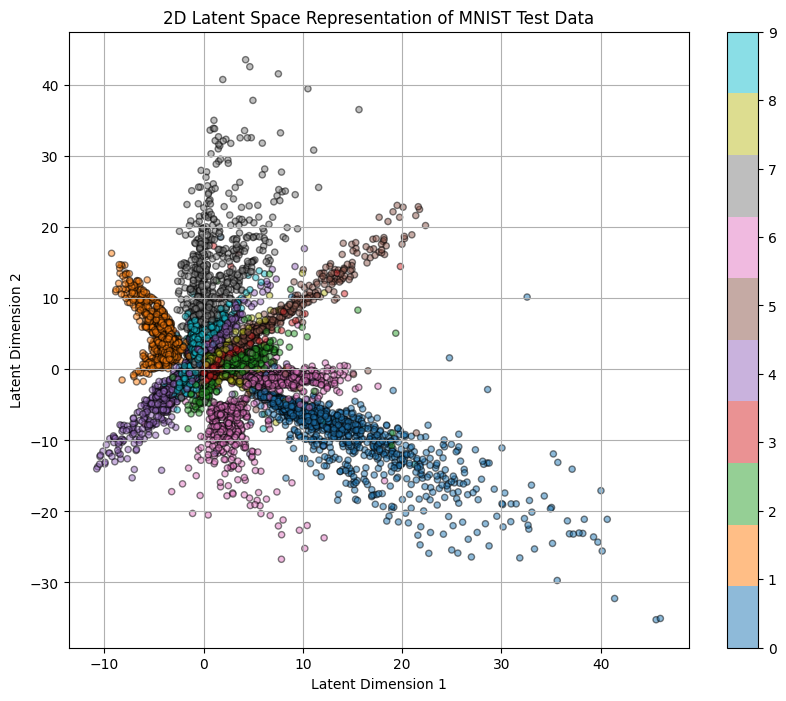

In [ ]:
# Test the autoencoder and plot the latent space
model.eval()
all_encoded = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.view(-1, 784).to(device)  # Move inputs to the same device as the model
        encoded, _ = model(inputs)
        all_encoded.append(encoded.cpu())
        all_labels.append(labels.cpu())

# Concatenate all the encoded outputs and labels
all_encoded = torch.cat(all_encoded)
all_labels = torch.cat(all_labels)

# Plot the 2D latent space with clearer distinctions between clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_encoded[:, 0], all_encoded[:, 1], c=all_labels, cmap='tab10', alpha=0.5, edgecolors='k', s=20)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Representation of MNIST Test Data')
plt.grid(True)
plt.show()


Is it possible that such a tendency only occurs in the test data? Let's also examine how each number is distributed in the semantic space with respect to the **training data**.

In [ ]:
model.eval()
all_encoded_train = []
all_labels_train = []

with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.view(-1, 784).to(device)  # Move inputs to the same device as the model
        encoded, _ = model(inputs)
        all_encoded_train.append(encoded.cpu())
        all_labels_train.append(labels.cpu())

# Concatenate all the encoded outputs and labels
all_encoded_train = torch.cat(all_encoded_train)
all_labels_train = torch.cat(all_labels_train)

# Plot the 2D latent space with clearer distinctions between clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(all_encoded_train[:, 0], all_encoded_train[:, 1], c=all_labels_train, cmap='tab10', alpha=0.5, edgecolors='k', s=20)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Representation of MNIST Train Data')
plt.grid(True)
plt.show()


The visualization reveals that, despite the small dimensionality of the latent space, many vectors overlap significantly. This suggests that the learned space is ***not continuous*** but rather behaves like a ***code*** where each digit is assigned a specific position, leading to substantial overlap among different digits. This observation highlights a limitation of basic autoencoders in learning smooth and continuous representations. To address this issue, we can extend our approach to Variational Autoencoders (VAEs), which are designed to learn more continuous and meaningful latent spaces by incorporating probabilistic elements into the encoding process. This extension allows for better generalization and more nuanced data representations.

## Enhancing the Latent Space

At this point, we can see that it is challenging to generate fully intact images with a simple 2-dimensional vector representation. To address this, we will maintain the structure of the autoencoder but increase the dimensionality of the bottleneck latent space. This will allow us to train the model again and observe the results, aiming for improved reconstruction quality.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        # decoder part
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 784)

    def encoder(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def decoder(self, x):
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = Autoencoder()
model.to(device)

# define loss and parameters
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()

epoch = 100
for i in range(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # prepare input data
        data = data.cuda()
        inputs = torch.reshape(data,(-1, 784)) # to match shape

        # forward pass
        optimizer.zero_grad()
        recon_x = model(inputs)
        loss = loss_function(recon_x, inputs)

        # backward pass
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    if i%10==0:
        print('Epoch: {} Average loss: {:.9f}'.format(i, train_loss ))


Epoch: 0 Average loss: 16.566927206
Epoch: 10 Average loss: 4.418627763
Epoch: 20 Average loss: 2.518063659
Epoch: 30 Average loss: 1.837789439
Epoch: 40 Average loss: 1.500398368
Epoch: 50 Average loss: 1.283699735
Epoch: 60 Average loss: 1.138390566
Epoch: 70 Average loss: 1.035166382
Epoch: 80 Average loss: 0.954990636
Epoch: 90 Average loss: 0.889290692


In [ ]:
def visualize_reconstructions(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients for visualization
        # Get a batch of data
        for batch, _ in data_loader:
            batch = batch.to(device)

            # Forward pass
            input_images = torch.reshape(batch,(-1, 784)) # to match shape
            reconstructions = model(input_images)
            break  # We only need one batch for visualization

    # Move tensors to CPU for plotting
    batch = batch.cpu()
    reconstructions = reconstructions.cpu()
    reconstructions = torch.reshape(reconstructions, (-1, 28, 28))

    # Plotting
    fig, axs = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axs[0, i].imshow(batch[i].squeeze(), cmap='gray')  # Original images
        axs[0, i].axis('off')
        axs[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')  # Reconstructed images
        axs[1, i].axis('off')

    axs[0, 0].set_title('Original Images')
    axs[1, 0].set_title('AE Reconstructions')
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(dataset=test_dataset, batch_size=5, shuffle=True)  # Set batch_size to 5 to get 5 random images

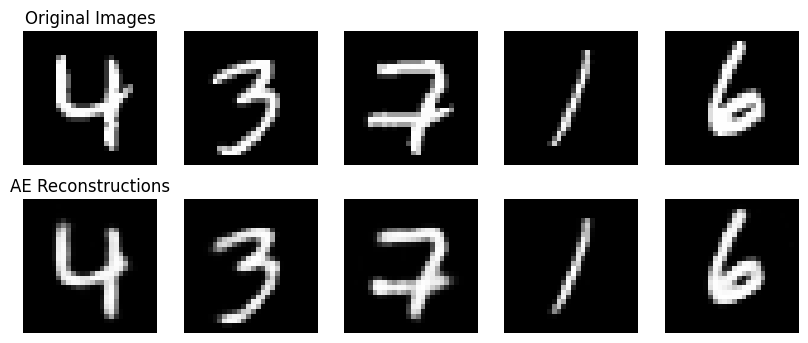

In [ ]:
# Example usage
visualize_reconstructions(model, test_loader, device)

After increasing the dimensionality of the bottleneck latent space and retraining the autoencoder, we evaluate the performance by visualizing the reconstructed images again. The results show that the images are now much closer to the original inputs, indicating that the higher-dimensional latent space allows for more accurate and detailed reconstructions.

## Conclusion

In this lecture, we explored the use of autoencoders to compress and reconstruct the MNIST dataset. We started by building a simple autoencoder with a 2-dimensional latent space, which demonstrated the limitations in generating high-quality images from such a low-dimensional representation. By increasing the dimensionality of the latent space, we observed significant improvements in the reconstruction quality, with the images closely resembling the original inputs. This exercise highlighted the importance of the latent space dimensionality in autoencoders and its impact on the fidelity of the reconstructed data.

Additionally, we observed that the latent representations learned by the autoencoder are not continuous but rather function more like a code, assigning specific positions to different images. This understanding paves the way for extending our approach to Variational Autoencoders (VAEs), which aim to learn continuous and more meaningful latent spaces. Overall, we gained practical insights into the workings of autoencoders, the trade-offs involved in choosing the latent space dimensions, and the potential for further advancements with VAEs.

